In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import backend as Kb
import matplotlib.pyplot as plt

print(tf.__version__)
print(K.__version__)
warnings.filterwarnings("default")

1.14.0
2.2.4-tf


# VQ-VAE
---


In [2]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train[..., None] / 255., y_train), (x_test[..., None] / 255., y_test)

(x_train, y_train), (x_test, y_test) = load_data('../input/mnist.npz')
print("Train images:", x_train.shape)
print("Train labels:", y_train.shape)

Train images: (60000, 28, 28, 1)
Train labels: (60000,)


In [3]:
# Hyperparameters
NUM_LATENT_K = 10                 # Number of codebook entries
NUM_LATENT_D = 64                 # Dimension of each codebook entries
BETA = 1.0                        # Weight for the commitment loss

INPUT_SHAPE = x_train.shape[1:]
SIZE = None                       # Spatial size of latent embedding
                                  # will be set dynamically in `build_vqvae

VQVAE_BATCH_SIZE = 128            # Batch size for training the VQVAE
VQVAE_NUM_EPOCHS = 20             # Number of epochs
VQVAE_LEARNING_RATE = 3e-4        # Learning rate
VQVAE_LAYERS = [16, 32]           # Number of filters for each layer in the encoder

PIXELCNN_BATCH_SIZE = 128         # Batch size for training the PixelCNN prior
PIXELCNN_NUM_EPOCHS = 10          # Number of epochs
PIXELCNN_LEARNING_RATE = 3e-4     # Learning rate
PIXELCNN_NUM_BLOCKS = 12          # Number of Gated PixelCNN blocks in the architecture
PIXELCNN_NUM_FEATURE_MAPS = 32    # Width of each PixelCNN block

# Building the generative model


In [4]:
class VectorQuantizer(K.layers.Layer):  
    def __init__(self, k, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.k = k
    
    def build(self, input_shape):
        self.d = int(input_shape[-1])
        rand_init = K.initializers.VarianceScaling(distribution="uniform")
        self.codebook = self.add_weight(shape=(self.k, self.d), initializer=rand_init, trainable=True)
        
    def call(self, inputs):
        # Map z_e of shape (b, w,, h, d) to indices in the codebook
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        z_e = tf.expand_dims(inputs, -2)
        dist = tf.norm(z_e - lookup_, axis=-1)
        k_index = tf.argmin(dist, axis=-1)
        return k_index
    
    def sample(self, k_index):
        # Map indices array of shape (b, w, h) to actual codebook z_q
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        k_index_one_hot = tf.one_hot(k_index, self.k)
        z_q = lookup_ * k_index_one_hot[..., None]
        z_q = tf.reduce_sum(z_q, axis=-2)
        return z_q

In [5]:
def encoder_pass(inputs, d, num_layers=[16, 32]):
    x = inputs
    for i, filters in enumerate(num_layers):
        x = K.layers.Conv2D(filters=filters, kernel_size=3, padding='SAME', activation='relu', 
                            strides=(2, 2), name="conv{}".format(i + 1))(x)
    z_e = K.layers.Conv2D(filters=d, kernel_size=3, padding='SAME', activation=None,
                          strides=(1, 1), name='z_e')(x)
    return z_e

def decoder_pass(inputs, num_layers=[32, 16]):
    y = inputs
    for i, filters in enumerate(num_layers):
        y = K.layers.Conv2DTranspose(filters=filters, kernel_size=4, strides=(2, 2), padding="SAME", 
                                     activation='relu', name="convT{}".format(i + 1))(y)
    decoded = K.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), 
                                       padding="SAME", activation='sigmoid', name='output')(y)
    return decoded

In [6]:
def build_vqvae(k, d, input_shape=(28, 28, 1), num_layers=[16, 32]):
    global SIZE
    ## Encoder
    encoder_inputs = K.layers.Input(shape=input_shape, name='encoder_inputs')
    z_e = encoder_pass(encoder_inputs, d, num_layers=num_layers)
    SIZE = int(z_e.get_shape()[1])

    ## Vector Quantization
    vector_quantizer = VectorQuantizer(k, name="vector_quantizer")
    codebook_indices = vector_quantizer(z_e)
    encoder = K.Model(inputs=encoder_inputs, outputs=codebook_indices, name='encoder')

    ## Decoder
    decoder_inputs = K.layers.Input(shape=(SIZE, SIZE, d), name='decoder_inputs')
    decoded = decoder_pass(decoder_inputs, num_layers=num_layers[::-1])
    decoder = K.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')
    
    ## VQVAE Model (training)
    sampling_layer = K.layers.Lambda(lambda x: vector_quantizer.sample(x), name="sample_from_codebook")
    z_q = sampling_layer(codebook_indices)
    codes = tf.stack([z_e, z_q], axis=-1)
    codes = K.layers.Lambda(lambda x: x, name='latent_codes')(codes)
    straight_through = K.layers.Lambda(lambda x : x[1] + tf.stop_gradient(x[0] - x[1]), name="straight_through_estimator")
    straight_through_zq = straight_through([z_q, z_e])
    reconstructed = decoder(straight_through_zq)
    vq_vae = K.Model(inputs=encoder_inputs, outputs=[reconstructed, codes], name='vq-vae')
    
    ## VQVAE model (inference)
    codebook_indices = K.layers.Input(shape=(SIZE, SIZE), name='discrete_codes', dtype=tf.int32)
    z_q = sampling_layer(codebook_indices)
    generated = decoder(z_q)
    vq_vae_sampler = K.Model(inputs=codebook_indices, outputs=generated, name='vq-vae-sampler')
    
    ## Transition from codebook indices to model (for training the prior later)
    indices = K.layers.Input(shape=(SIZE, SIZE), name='codes_sampler_inputs', dtype='int32')
    z_q = sampling_layer(indices)
    codes_sampler = K.Model(inputs=indices, outputs=z_q, name="codes_sampler")
    
    ## Getter to easily access the codebook for vizualisation
    indices = K.layers.Input(shape=(), dtype='int32')
    vector_model = K.Model(inputs=indices, outputs=vector_quantizer.sample(indices[:, None, None]), name='get_codebook')
    def get_vq_vae_codebook():
        codebook = vector_model.predict(np.arange(k))
        codebook = np.reshape(codebook, (k, d))
        return codebook
    
    return vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook

vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook = build_vqvae(
    NUM_LATENT_K, NUM_LATENT_D, input_shape=INPUT_SHAPE, num_layers=VQVAE_LAYERS)
vq_vae.summary()

Model: "vq-vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 16)   160         encoder_inputs[0][0]             
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 7, 7, 32)     4640        conv1[0][0]                      
__________________________________________________________________________________________________
z_e (Conv2D)                    (None, 7, 7, 64)     18496       conv2[0][0]                      
_____________________________________________________________________________________________

# Training the VQ-VAE



In [7]:
def mse_loss(ground_truth, predictions):
    mse_loss = tf.reduce_mean((ground_truth - predictions)**2, name="mse_loss")
    return mse_loss

def latent_loss(dummy_ground_truth, outputs):
    global BETA
    del dummy_ground_truth
    z_e, z_q = tf.split(outputs, 2, axis=-1)
    vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)
    commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)
    latent_loss = tf.identity(vq_loss + BETA * commit_loss, name="latent_loss")
    return latent_loss    

In [8]:
def zq_norm(y_true, y_pred):
    del y_true
    _, z_q = tf.split(y_pred, 2, axis=-1)
    return tf.reduce_mean(tf.norm(z_q, axis=-1))

def ze_norm(y_true, y_pred):
    del y_true
    z_e, _ = tf.split(y_pred, 2, axis=-1)
    return tf.reduce_mean(tf.norm(z_e, axis=-1))

In [9]:
%%time
## Compile and train
vq_vae.compile(loss=[mse_loss, latent_loss], metrics={"latent_codes": [zq_norm, ze_norm]}, optimizer= K.optimizers.Adam(VQVAE_LEARNING_RATE))
history = vq_vae.fit(x_train, [x_train, None], epochs=VQVAE_NUM_EPOCHS, batch_size=VQVAE_BATCH_SIZE, verbose=2)

Epoch 1/20
60000/60000 - 5s - loss: 0.1070 - decoder_loss: 0.0730 - latent_codes_loss: 0.0340 - latent_codes_zq_norm: 0.2364 - latent_codes_ze_norm: 0.2204
Epoch 2/20
60000/60000 - 3s - loss: 0.0708 - decoder_loss: 0.0350 - latent_codes_loss: 0.0358 - latent_codes_zq_norm: 0.2594 - latent_codes_ze_norm: 0.2788
Epoch 3/20
60000/60000 - 3s - loss: 0.0648 - decoder_loss: 0.0238 - latent_codes_loss: 0.0410 - latent_codes_zq_norm: 0.2680 - latent_codes_ze_norm: 0.2902
Epoch 4/20
60000/60000 - 3s - loss: 0.0469 - decoder_loss: 0.0186 - latent_codes_loss: 0.0283 - latent_codes_zq_norm: 0.2825 - latent_codes_ze_norm: 0.2996
Epoch 5/20
60000/60000 - 3s - loss: 0.0468 - decoder_loss: 0.0174 - latent_codes_loss: 0.0294 - latent_codes_zq_norm: 0.3002 - latent_codes_ze_norm: 0.3161
Epoch 6/20
60000/60000 - 3s - loss: 0.0474 - decoder_loss: 0.0168 - latent_codes_loss: 0.0307 - latent_codes_zq_norm: 0.3130 - latent_codes_ze_norm: 0.3280
Epoch 7/20
60000/60000 - 3s - loss: 0.0474 - decoder_loss: 0.016

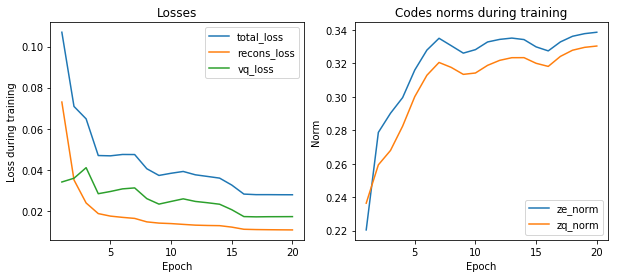

In [10]:
num_epochs = range(1, len(history.history["loss"]) + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(num_epochs, history.history["loss"], label="total_loss")
plt.plot(num_epochs, history.history["decoder_loss"], label="recons_loss")
plt.plot(num_epochs, history.history["latent_codes_loss"], label="vq_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss during training")
plt.legend()
plt.title("Losses")
plt.subplot(1, 2, 2)
plt.plot(num_epochs, history.history["latent_codes_ze_norm"], label="ze_norm")
plt.plot(num_epochs, history.history["latent_codes_zq_norm"], label="zq_norm")
plt.xlabel("Epoch")
plt.ylabel("Norm")
plt.title("Codes norms during training")
plt.legend()
plt.show()

Originals versus reconstructions


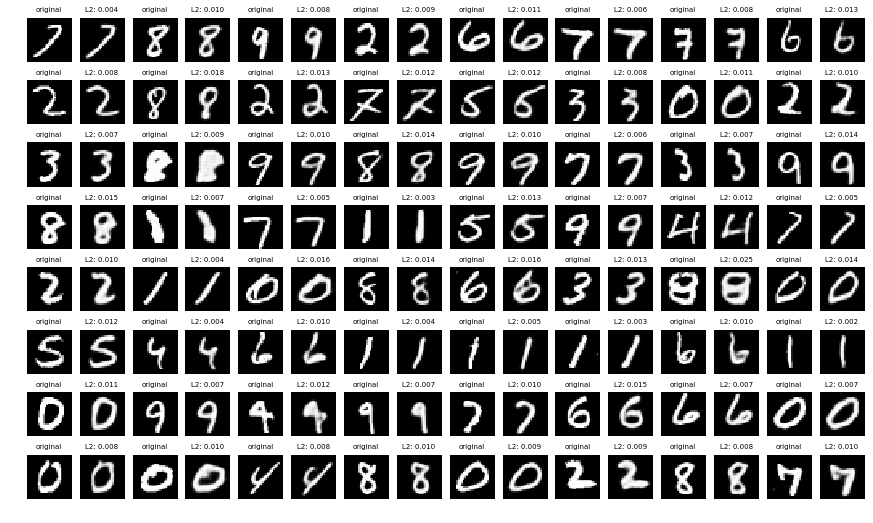

In [11]:
# original versus reconstructions
def recons(model, images, n_row, n_col, random=True):
    n = n_row * n_col
    if random:
        x = np.random.choice(images.shape[0], size=n, replace=False)
        x = images[x]
    else:
        x = images[:n]
    recons, _ = model.predict(x)
    dists = np.mean((recons - x)**2, axis=(1, 2, 3))
    plt.figure(figsize=(15, 9))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(x[i, :, :, 0], cmap='gray')
        plt.title("original", fontsize=7)
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(recons[i, :, :, 0], cmap='gray')
        plt.title("L2: {:.3f}".format(dists[i]), fontsize=7)
        plt.axis('off')
    plt.show()
    
print("Originals versus reconstructions")
recons(vq_vae, x_test, 8, 8)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


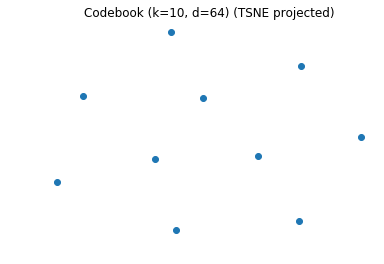

In [12]:
from sklearn.manifold import TSNE
codebook = get_vq_vae_codebook()
codebook = TSNE(2).fit_transform(codebook)
plt.title("Codebook (k={}, d={}) (TSNE projected)".format(NUM_LATENT_K, NUM_LATENT_D))
plt.scatter(codebook[:, 0], codebook[:, 1])
plt.axis('off')
plt.show()

# Learning a prior over the latent space
---


Images generated under a uniform prior (training assumption)


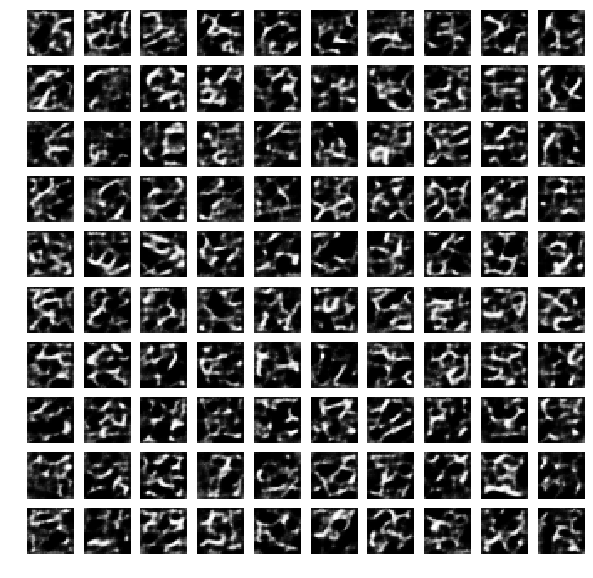

In [13]:
def generate_from_random(sampler, k, size, n_row, n_col):
    n = n_col * n_row
    indices = np.random.randint(0, k, size=(n, size, size))
    generated = sampler.predict(indices, steps=1)
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(n_row,n_col,i+1)
        plt.imshow(generated[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()
    
print("Images generated under a uniform prior (training assumption)")
generate_from_random(vq_vae_sampler, NUM_LATENT_K, SIZE, 10, 10)

In [14]:
def gate(inputs):
    """Gated activations"""
    x, y = tf.split(inputs, 2, axis=-1)
    return Kb.tanh(x) * Kb.sigmoid(y)


class MaskedConv2D(K.layers.Layer):
    """Masked convolution"""
    def __init__(self, kernel_size, out_dim, direction, mode, **kwargs):
        self.direction = direction     # Horizontal or vertical
        self.mode = mode               # Mask type "a" or "b"
        self.kernel_size = kernel_size
        self.out_dim = out_dim
        super(MaskedConv2D, self).__init__(**kwargs)
    
    def build(self, input_shape):   
        filter_mid_y = self.kernel_size[0] // 2
        filter_mid_x = self.kernel_size[1] // 2        
        in_dim = int(input_shape[-1])
        w_shape = [self.kernel_size[0], self.kernel_size[1], in_dim, self.out_dim]
        mask_filter = np.ones(w_shape, dtype=np.float32)
        # Build the mask
        if self.direction == "h":
            mask_filter[filter_mid_y + 1:, :, :, :] = 0.
            mask_filter[filter_mid_y, filter_mid_x + 1:, :, :] = 0.
        elif self.direction == "v":
            if self.mode == 'a':
                mask_filter[filter_mid_y:, :, :, :] = 0.
            elif self.mode == 'b':
                mask_filter[filter_mid_y+1:, :, :, :] = 0.0
        if self.mode == 'a':
            mask_filter[filter_mid_y, filter_mid_x, :, :] = 0.0
        # Create convolution layer parameters with masked kernel
        self.W = mask_filter * self.add_weight("W_{}".format(self.direction), w_shape, trainable=True)
        self.b = self.add_weight("v_b", [self.out_dim,], trainable=True)
    
    def call(self, inputs):
        return K.backend.conv2d(inputs, self.W, strides=(1, 1)) + self.b

    
def gated_masked_conv2d(v_stack_in, h_stack_in, out_dim, kernel, mask='b', residual=True, i=0):
    """Basic Gated-PixelCNN block. 
       This is an improvement over PixelRNN to avoid "blind spots", i.e. pixels missingt from the
       field of view. It works by having two parallel stacks, for the vertical and horizontal direction, 
       each being masked  to only see the appropriate context pixels.
    """
    kernel_size = (kernel // 2 + 1, kernel)
    padding = (kernel // 2, kernel // 2)
        
    v_stack = K.layers.ZeroPadding2D(padding=padding, name="v_pad_{}".format(i))(v_stack_in)
    v_stack = MaskedConv2D(kernel_size, out_dim * 2, "v", mask, name="v_masked_conv_{}".format(i))(v_stack)
    v_stack = v_stack[:, :int(v_stack_in.get_shape()[-3]), :, :]
    v_stack_out = K.layers.Lambda(lambda inputs: gate(inputs), name="v_gate_{}".format(i))(v_stack)
    
    kernel_size = (1, kernel // 2 + 1)
    padding = (0, kernel // 2)
    h_stack = K.layers.ZeroPadding2D(padding=padding, name="h_pad_{}".format(i))(h_stack_in)
    h_stack = MaskedConv2D(kernel_size, out_dim * 2, "h", mask, name="h_masked_conv_{}".format(i))(h_stack)
    h_stack = h_stack[:, :, :int(h_stack_in.get_shape()[-2]), :]
    h_stack_1 = K.layers.Conv2D(filters=out_dim * 2, kernel_size=1, strides=(1, 1), name="v_to_h_{}".format(i))(v_stack)
    h_stack_out = K.layers.Lambda(lambda inputs: gate(inputs), name="h_gate_{}".format(i))(h_stack + h_stack_1)
    
    h_stack_out =  K.layers.Conv2D(filters=out_dim, kernel_size=1, strides=(1, 1), name="res_conv_{}".format(i))(h_stack_out)
    if residual:
        h_stack_out += h_stack_in
    return v_stack_out, h_stack_out

# Prior training data


In [15]:
# Dataset to train the Prior
z_train = encoder.predict(x_train)
z_train.shape

(60000, 7, 7)

Images encoded as discrete codes


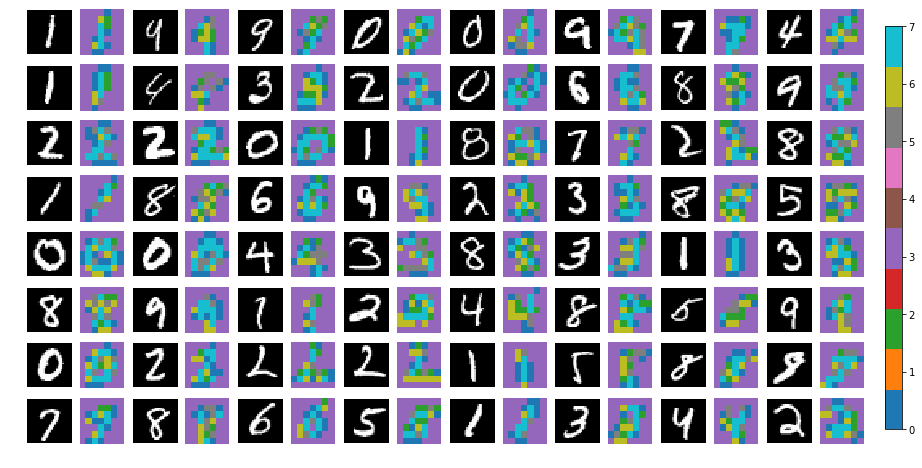

In [16]:
# original versus reconstructions
def viz_codes(encoder, images, n_row, n_col, random=True):
    n = n_row * n_col
    if random:
        x = np.random.choice(images.shape[0], size=n, replace=False)
        x = images[x]
    else:
        x = images[:n]
    codes = encoder.predict(x)
    fig = plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2*i+1)
        plt.imshow(x[i,:,:,0], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2*i+2)
        plt.pcolor(codes[i, ::-1, :], cmap='tab10') #flip y-axis origin to match imshow
        plt.axis('off')
    cbaxes = fig.add_axes([0.92, 0.15, 0.015, 0.7]) 
    cb = plt.colorbar(cax=cbaxes)  
    plt.show()
    
    
print("Images encoded as discrete codes")
viz_codes(encoder, x_test, 8, 8)

In [17]:
def build_pixelcnn(codes_sampler, k, size, num_layers, num_feature_maps=32):
    pixelcnn_prior_inputs = K.layers.Input(shape=(size, size), name='pixelcnn_prior_inputs', dtype=tf.int32)
    z_q = tf.to_float(tf.one_hot(pixelcnn_prior_inputs, k))
    v_stack_in, h_stack_in = z_q, z_q
    for i in range(num_layers):
        mask = 'b' if i > 0 else 'a'
        kernel_size = 3 if i > 0 else 7
        residual = True if i > 0 else False
        v_stack_in, h_stack_in = gated_masked_conv2d(v_stack_in, h_stack_in, num_feature_maps,
                                                     kernel=kernel_size, residual=residual, i=i + 1)

    fc1 = K.layers.Conv2D(filters=num_feature_maps, kernel_size=1, name="fc1")(h_stack_in)
    fc2 = K.layers.Conv2D(filters=k, kernel_size=1, name="fc2")(fc1) 
    pixelcnn_prior = K.Model(inputs=pixelcnn_prior_inputs, outputs=fc2, name='pixelcnn-prior')
    dist = tf.distributions.Categorical(logits=fc2)
    sampled = dist.sample()
    prior_sampler = K.Model(inputs=pixelcnn_prior_inputs, outputs=sampled, name='pixelcnn-prior-sampler')
    return pixelcnn_prior, prior_sampler

pixelcnn_prior, prior_sampler = build_pixelcnn(codes_sampler, NUM_LATENT_K, SIZE, 
                                               PIXELCNN_NUM_BLOCKS, PIXELCNN_NUM_FEATURE_MAPS)
#pixelcnn_prior.summary()

# Training and Testing the prior

In [18]:
%%time
# Train the PixelCNN and monitor prediction accuracy
def accuracy(y_true, y_pred):
    size = int(y_pred.get_shape()[-2])
    k = int(y_pred.get_shape()[-1])
    y_true = tf.reshape(y_true, (-1, size * size))
    y_pred = tf.reshape(y_pred, (-1, size * size, k))
    return Kb.cast(Kb.equal(y_true, Kb.cast(Kb.argmax(y_pred, axis=-1), Kb.floatx())), Kb.floatx())

pixelcnn_prior.compile(loss=K.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[accuracy],
                       optimizer=K.optimizers.Adam(PIXELCNN_LEARNING_RATE))

prior_history = pixelcnn_prior.fit(z_train, z_train, epochs=PIXELCNN_NUM_EPOCHS, 
                                   batch_size=PIXELCNN_BATCH_SIZE, verbose=1)

Epoch 1/10
60000/60000 [==============================] - 12s 192us/sample - loss: 0.8853 - accuracy: 0.6713
Epoch 2/10
60000/60000 [==============================] - 10s 161us/sample - loss: 0.7413 - accuracy: 0.7108
Epoch 3/10
60000/60000 [==============================] - 10s 159us/sample - loss: 0.7013 - accuracy: 0.7253
Epoch 4/10
60000/60000 [==============================] - 10s 163us/sample - loss: 0.6794 - accuracy: 0.7331
Epoch 5/10
60000/60000 [==============================] - 10s 164us/sample - loss: 0.6653 - accuracy: 0.7381
Epoch 6/10
60000/60000 [==============================] - 10s 160us/sample - loss: 0.6550 - accuracy: 0.7418
Epoch 7/10
60000/60000 [==============================] - 10s 159us/sample - loss: 0.6472 - accuracy: 0.7449
Epoch 8/10
60000/60000 [==============================] - 10s 162us/sample - loss: 0.6408 - accuracy: 0.7473
Epoch 9/10
60000/60000 [==============================] - 10s 159us/sample - loss: 0.6358 - accuracy: 0.7493
Epoch 10/10
60000/6

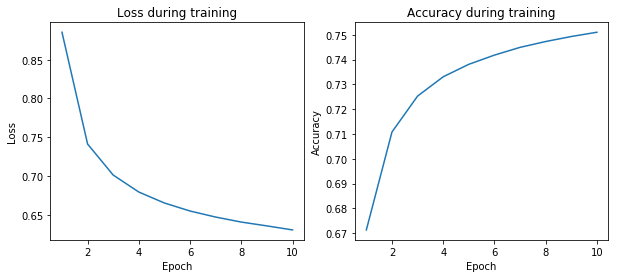

In [19]:
num_epochs = range(1, len(prior_history.history["loss"]) + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(num_epochs, prior_history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during training")
plt.subplot(1, 2, 2)
plt.plot(num_epochs, prior_history.history["accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy during training")
plt.show()

Originals versus reconstructions


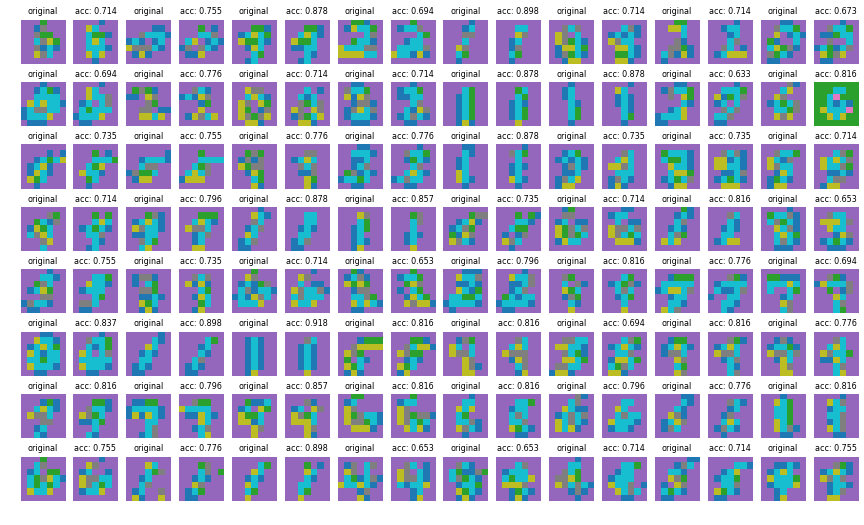

In [20]:
def recons_prior(model, z, n_row, n_col, random=True):
    n = n_row * n_col
    if random:
        x = np.random.choice(z.shape[0], size=n, replace=False)
        x = z[x]
    else:
        x = z[:n]
    recons = model.predict(x)
    recons = np.argmax(recons, axis=-1)
    accs = np.mean(np.equal(recons, x), axis=(1, 2))
    plt.figure(figsize=(15, 9))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(x[i], cmap='tab10')
        plt.title("original", fontsize=8)
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(recons[i], cmap='tab10')
        plt.title("acc: {:.3f}".format(accs[i]), fontsize=8)
        plt.axis('off')
    plt.show()
    
print("Originals versus reconstructions")
z_test = encoder.predict(x_test)
recons_prior(pixelcnn_prior, z_test, 8, 8)

Random codes sampled from the prior and corresponding decoded images


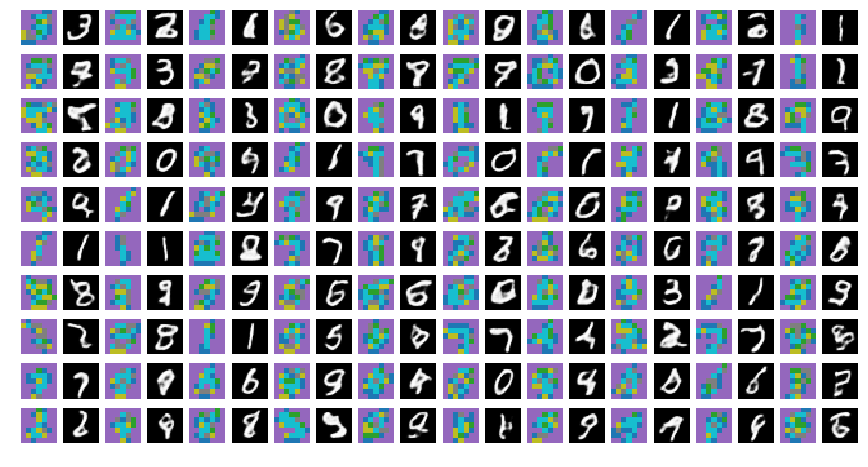

In [21]:
def sample_from_prior(prior, shape):
    """sample from the PixelCNN prior, pixel by pixel"""
    global prior_sampler
    X = np.zeros(shape, dtype=np.int32)
    for i in range(X.shape[1]):
        for j in range(X.shape[2]):
            sampled = prior_sampler.predict(X)
            X[:, i, j] = sampled[:, i, j]
    return X
            
    
def generate(prior, codes_sampler, size, n_row, n_col):
    """Generate random images by sampling codes from the given prior"""
    n = n_col * n_row
    indices = sample_from_prior(prior, (n, size, size))
    zq = codes_sampler(indices)
    generated = decoder.predict(zq, steps=1)
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(indices[i], cmap='tab10')
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(generated[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()
    
print("Random codes sampled from the prior and corresponding decoded images")
generate(prior_sampler, codes_sampler, SIZE, 10, 10)